In [236]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

l = 1 # m - Lengden av snora
g = 9.8 #m/s^2 - Tyngdeakselerasjon
theta_0 = 0.2 #rad - Initial vinkel med hensyn til vertikalen
theta_dot_0 = 0.0 #rad/s - Initial vinkelhastighet 
q = 1.0 #Hz - Friksjonsparameter
omega_D = 3.13 #rad/s - Drivkraftens vinkelfrekvens
drivkraft = 0.2 #s^-2 - Drivkraft

### Oppgave 1:
Bruk fjørne ordenens Runge-Kutta (RK4) metiden fir å løse bevegelseslikningen. Plot vinkelutslaget som funksjon av tid, opp til $t = 20s$. Bruk tidssteg $\Delta t = 0.01s$

In [ ]:

newparams = {'figure.figsize': (18, 9), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 25, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}

plt.rcParams.update(newparams) # Updates the parametere set above. 

#RK4 metode kopiert fra tidligere numerisk øving

def equation(t, vals): 
    """
    Calculates the RHS of the differential equations given an array (vals) which contains the parameters

    Parameters
    -----------
    t: (float) time
    vals: (array) values of theta and omega, [theta, omega] 
    
    Returns
    -------
    array with values of the RHS of the equations.
    """
    
    theta, omega = vals
    dtheta = omega
    domega = -q * omega - (g/l) * theta + drivkraft * np.sin(omega_D*t) #Endringer her siden det er flere variabler
    return np.array([dtheta, domega])

def RK4_step(RHS, vals, t, dt):
    """
    Calculates one step of the RK4-algorithm.
    
    RHS: (callable) function representing the right hand side of the differential equations
    vals: (numpy array) previous values of theta and omega, [theta, omega] 
    t: (float) previous time
    dt: (float) timestep
    
    return: (array) next values [theta_next, omega_next]
    """
    k1 = RHS(t, vals)   
    k2 = RHS(t+dt/2, vals+(dt/2)*k1)
    k3 = RHS(t+dt/2, vals+(dt/2)*k2)
    k4 = RHS(t+dt, vals+dt*k3)
    return vals + (dt/6)*(k1 + (2*k2) + (2*k3) + k4)

def RK4_method(RHS, theta_0, theta_dot_0, T, dt):
    """
    Computes theta and w (omega).  
    
    Parameters
    -----------
    k: RHS of equation
    f: RHS of equation
    theta0: initial value of theta
    w0: initail value of omega
    dt: timestep
    
    return theta, w, t
    """
    n = int(float(T)/dt) # number of iterations
    t = np.linspace(0, T, n + 1)
    theta, w = np.zeros(n+1), np.zeros(n+1)
    theta[0], w[0] = theta_0, theta_dot_0
    
    for i in range(n):
        theta[i+1], w[i+1] = RK4_step(RHS, np.array([theta[i], w[i]]), t[i], dt) 
        # Calculates values of theta and omega using RK4-method
        
    return theta, w, t

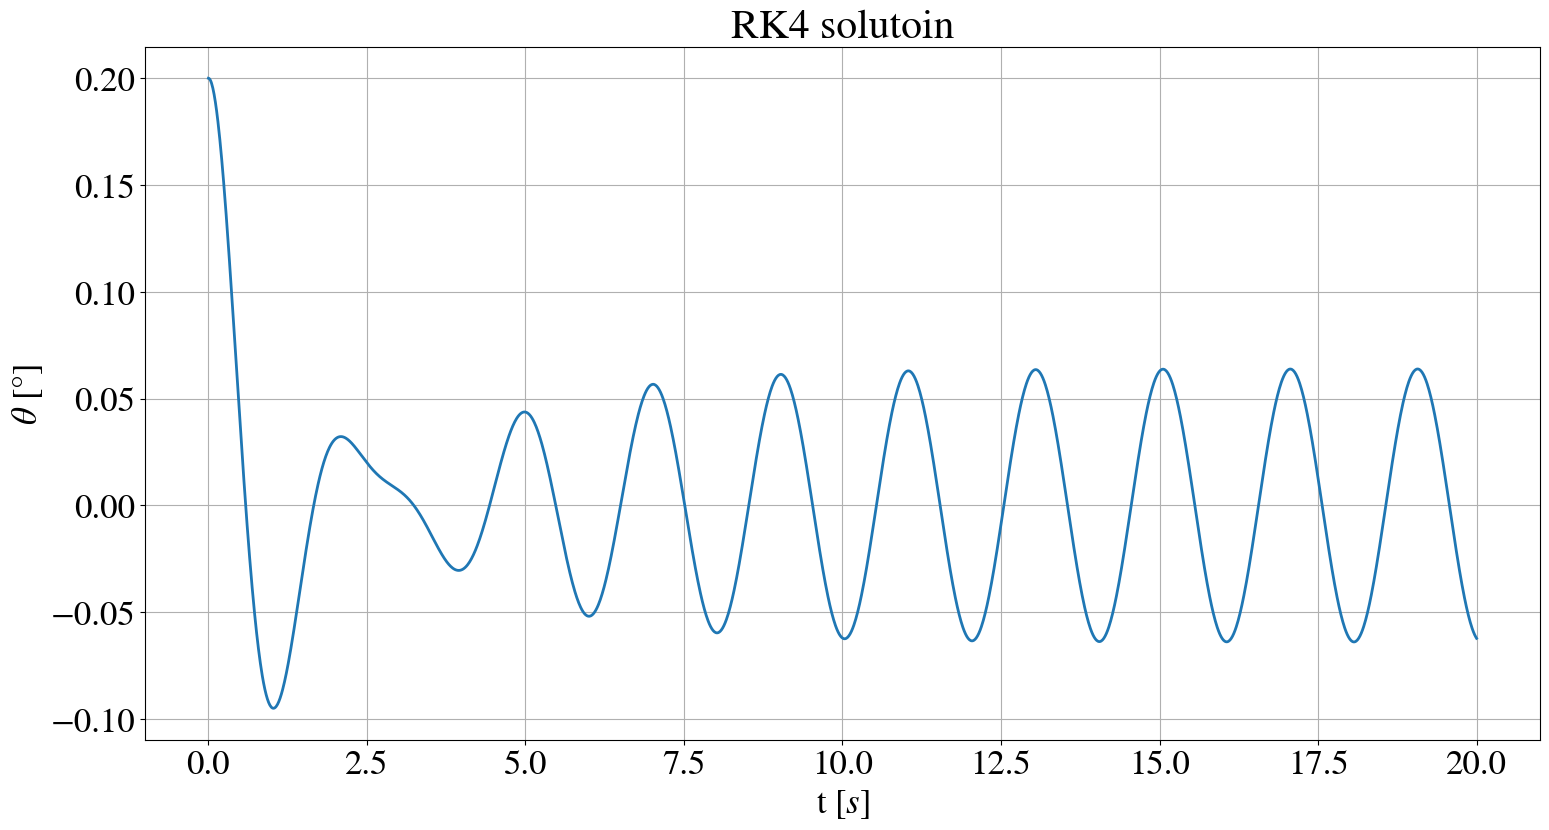

In [ ]:
theta_R, w_r, t = RK4_method(equation, theta_0, theta_dot_0, T=20, dt=0.01)

plt.plot(t, theta_R)
plt.title('RK4 solutoin')
plt.xlabel(r't $[s]$')
plt.ylabel(r'$\theta$ $[\degree]$')
plt.grid()
plt.show()

### Oppgave 2:
Finn en passende steglengde, $\Delta t$, ved å utføre en konvergenstest av løsningen fra RK4-metoden. Utfør den samme konvergenstesten for Euler-Cromer metoden, som du også må implementere. Plot de to konvergenstestene i hver sin figur. Vurder ut fra konvergenstesten om tidssteget brukt i oppgave 1 var tilstrekkelig. Merk at energien $\textit{ikke}$ vil være bevart i dette systemet.

In [239]:
def euler_cromer_step(RHS, vals, t, dt):
    """
    Calculates one step of the euler_cromer-algorithm.
    
    RHS: (callable) function representing the right hand side of the differential equations
    vals: (list) previous values of theta and omega, [theta, omega] 
    t: (float) previous time
    dt: (float) timestep
    
    return: (array) next values [theta_next, omega_next]
    """

    w_next = vals[1] + RHS(t, vals)[1] * dt
    theta_next = vals[0] + w_next * dt # uses w_next instead of w

    return (theta_next, w_next)

def euler_cromer(RHS, theta_0, theta_dot_0, T, dt):
    """
    Computes theta and w (omega).

    Parameters
    -----------
    k: RHS of equation
    f: RHS of equation
    theta0: initial value of theta
    w0: initail value of omega
    dt: timestep
    
    return theta, w, t
    """

    n = int(float(T)/dt) # number of iterations
    t = np.linspace(0, T, n + 1)
    theta, w = np.zeros(n+1), np.zeros(n+1)
    theta[0], w[0] = theta_0, theta_dot_0

    for i in range(n):
        theta[i+1], w[i+1] = euler_cromer_step(RHS, [theta[i], w[i]], t[i], dt)


    return theta, w, t



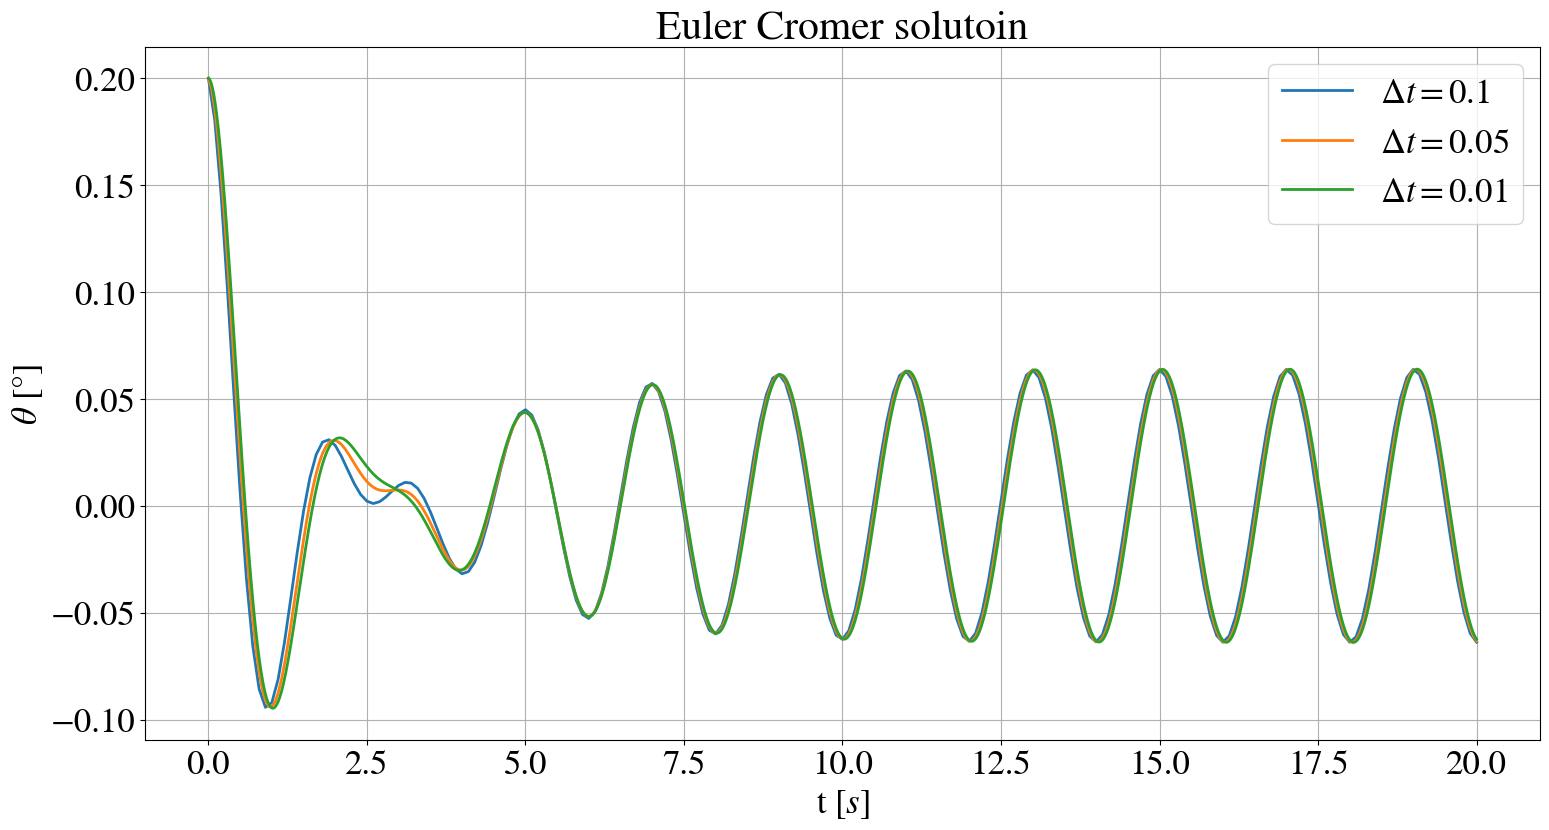

In [240]:
for dt in [0.1, 0.05, 0.01]:
    theta_R, w_r, t = euler_cromer(equation, theta_0, theta_dot_0, T=20,dt=dt)

    plt.plot(t, theta_R, label=r"$\Delta t = $" + str(dt))
    plt.title(f'Euler Cromer solutoin')
    plt.xlabel(r't $[s]$')
    plt.ylabel(r'$\theta$ $[\degree]$')
    plt.legend()
    plt.grid()
plt.show()

In [241]:
def generate_solutions(method, params, dt_max, dt_min, N):
    RHS, theta_0, theta_dot_0, T = params

    sols = []
    dts = np.logspace(np.log10(dt_max),np.log10(dt_min), N)
    
    for dt in dts:
        sols.append(method(RHS, theta_0, theta_dot_0, T, dt))

    return sols, dts


def compare_thetas(sol1, sol2):
    '''
    Compares to solutions to the system, by interpolating the solution with highest dt on the ohter solution's t-values.
    Calculates simularity score (mean absolute error).

    Parameters
    -----------
    sol1 (tuple): theta, w (omega) and t-values for 1st solution
    sol2 (tuple): theta, w (omega) and t-values for 2nd solution
    
    return simulatity_score
    '''

    if len(sol1[0])<len(sol2[0]):
        theta_1, _, t_1 = sol1
        theta_2, _, t_2 = sol2
    else:
        theta_1, _, t_1 = sol2
        theta_2, _, t_2 = sol1

    theta_1 = np.interp(t_2, t_1, theta_1)

    return np.mean(np.abs(theta_1-theta_2)) # return np.max(np.abs(theta_1-theta_2))

    
def compare_solutions(sols, dts):
    '''
    Compares multiple solutions to the system and graphs simularity score.

    Parameters
    -----------
    sols (tuple): list of solutions
    dts (tuple): list of dt-values

    return simulatity_scores
    '''
    print(sols)
    print(sols[0])
    print(sols[0][0])
    plt.plot(sols[0][2], sols[0][1])
    '''scores = np.zeros(len(dts)-1)

    for i in range(len(dts)-1):
        scores[i] = compare_thetas(sols[i],sols[i+1])
    
    plt.plot(dts[1:], scores, label=r"$\Del$")
    plt.title(f'Convergence test')
    plt.xlabel(r't $[s]$')
    plt.xlabel(r'MAE of sol $\Delta_{i}$ vs $\Delta_{i-1}$' )
    plt.legend()
    plt.grid()
        '''

    #return scores
    



<>:53: SyntaxWarning: invalid escape sequence '\D'
<>:53: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Oliver\AppData\Local\Temp\ipykernel_17844\873292434.py:53: SyntaxWarning: invalid escape sequence '\D'
  '''scores = np.zeros(len(dts)-1)


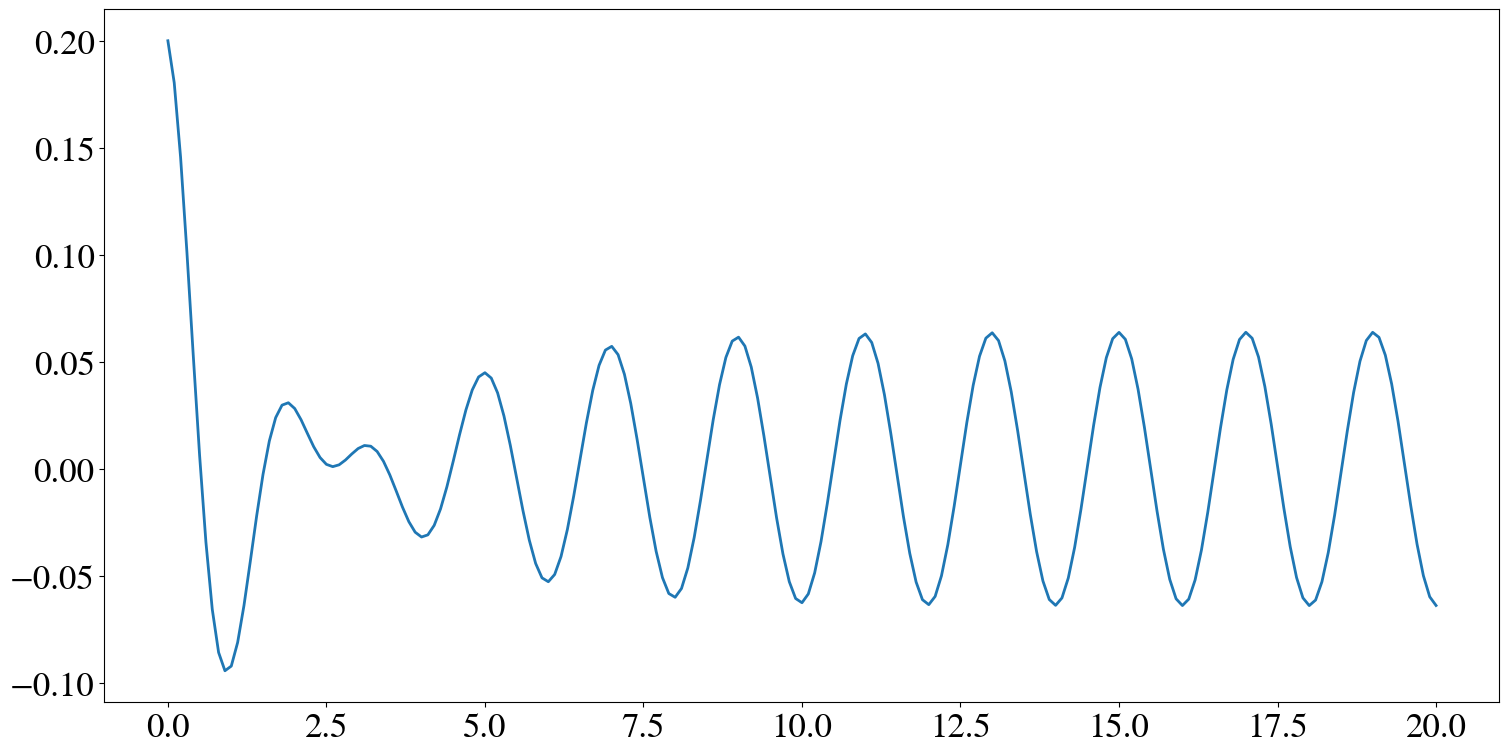

In [242]:
params = [equation, theta_0, theta_dot_0, 20]
sols = generate_solutions(euler_cromer, params, 0.1, 0.01, 20)

plt.plot(sols[0][0][2],sols[0][0][0])

In [243]:
params = (equation, theta_0, theta_dot_0, 20)
dt_max = 0.5
dt_min = 0.005
N = 20
T = 20

RK4_sols, RK4_dts = generate_solutions(RK4_method, params, dt_max, dt_min, N)
EC_sols, EC_dts = generate_solutions(euler_cromer, params, dt_max, dt_min, N)

In [244]:
len(RK4_sols[0][0])

1

[(array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.])), (array([0.2]), array([0.]), array([0.]))]
(array([0.2]), array([0.]), array([0.]))
[0.2]


[]

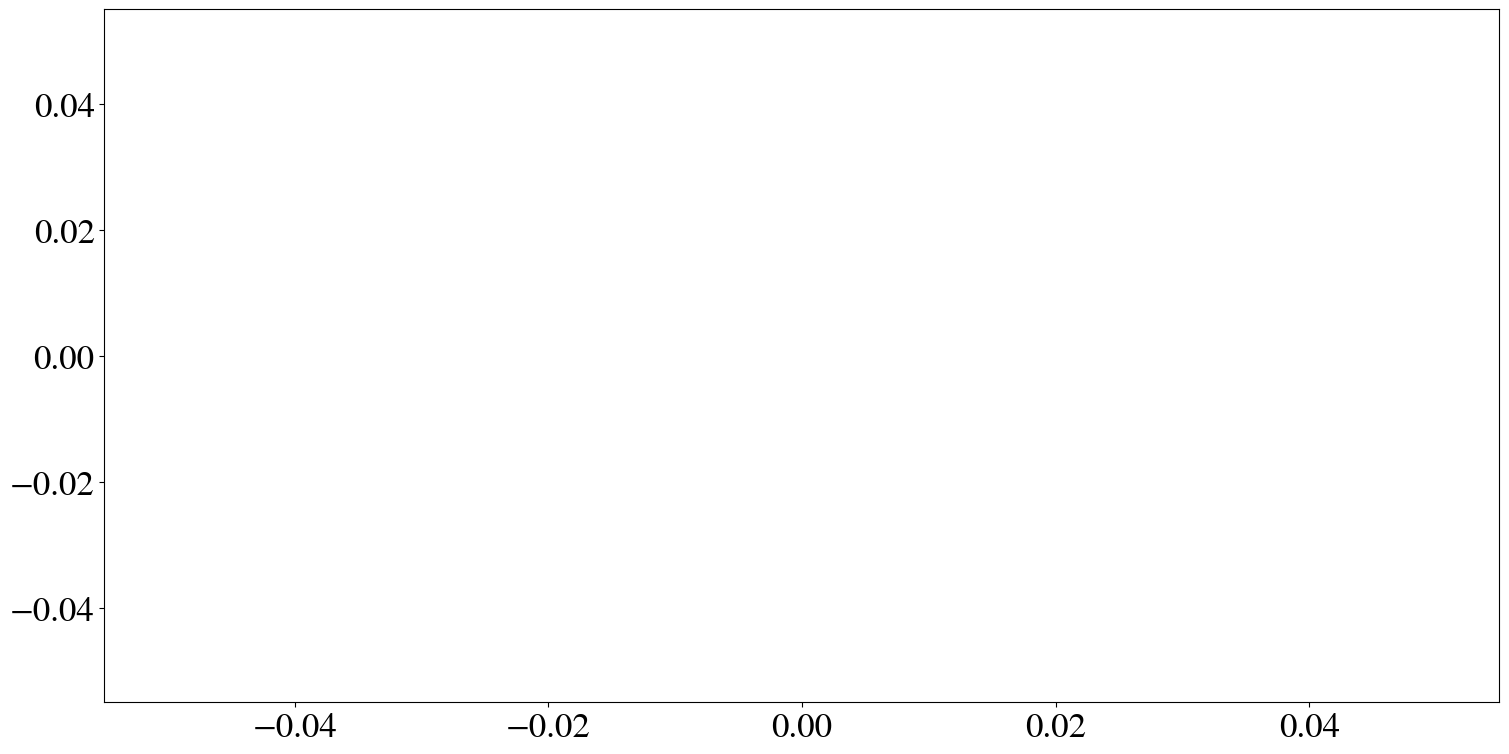

In [245]:
compare_solutions(RK4_sols, RK4_dts)
plt.plot()

In [246]:
np.logspace(-1,-3, 20)
np.log10(0.1)


np.float64(-1.0)

In [247]:
scores = np.zeros(len(dts)-1)

for i in range(len(dts)-1):
    scores[i] = compare_thetas(sols[i],sols[i+1])

plt.plot(dts[1:], scores, label=r"$\Del$")
plt.title(f'Convergence test')
plt.xlabel(r't $[s]$')
plt.xlabel(r'MAE of sol $\Delta_{i}$ vs $\Delta_{i-1}$' )
plt.legend()
plt.grid()
        

NameError: name 'dts' is not defined

In [ ]:
x = np.array([2,3,4])
xp = np.array([1,3,4])
yp = np.array([2,6,8])

np.interp(x,xp,yp)

array([4., 6., 8.])

In [ ]:
def printargs(*args):

    print(*args)

    print('test')

    iii(*args,2222)
    return args
printargs(1,2,34)


def iii(a,b,c,d):
    print(a)
    print(b)
    print(c)
    print(d)

1 2 34
test
1
2
34
2222
